In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
from matplotlib import rcParams
import seaborn as sns
from textwrap import wrap
from tqdm import tqdm
import pandas as pd
import re
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from torch_geometric.nn import knn

%matplotlib widget

In [4]:
def read_tensors_aux(dir, tensor_names=None):
    """ recursively read tensors from a directory """
    tensors = {}
    for path in os.listdir(dir):
        if path.endswith('.pt'):
            key = path[:-3]
            if tensor_names is None or key in tensor_names:
                try:
                    tensors[key] = torch.load(os.path.join(dir, path), map_location='cpu')
                except Exception as e:
                    print(f"Error loading tensor {key}: {e}")
        elif os.path.isdir(os.path.join(dir, path)):
            key = path.split('_')[1] if path.startswith('timestep_') else path 
            tensors[key] = read_tensors_aux(os.path.join(dir, path), tensor_names=tensor_names)
        else:
            print(f"Skipping {path}, not a tensor or directory")
    return tensors

def read_tensors(dir, prompts=None, tensor_names=None):
    tensors = {}
    
    prompts = [ x for x in os.listdir(dir) if x in prompts ] if prompts is not None else [ x for x in os.listdir(dir) if os.path.isdir(os.path.join(dir, x)) ]
    
    for prompt in prompts:
        tensors[prompt] = read_tensors_aux(dir=os.path.join(dir, prompt), tensor_names=tensor_names)
        
    return tensors

In [5]:
def normalize_tensor(tensor):
    """
    Normalize a tensor to the range [0, 1].
    tensor: [f, h, w]
    """
    min_val = tensor.min()
    max_val = tensor.max()
    if max_val - min_val == 0:
        return tensor
    t = (tensor - min_val) / (max_val - min_val)
    # change type to float32 for better visualization
    return t.float()

def animate_tensor(tensor, title, save_mp4_filename=None, fps=2, normalize=True):
    """
    tensor: [f, h, w]
    title: title of the animation
    save_mp4_filename: if provided, saves the animation as an mp4 file with this name
    fps: frames per second for the animation
    """
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    fig.tight_layout()

    ax.set_title(title, fontsize=20)
    tnsr = normalize_tensor(tensor[0,:,:]) if normalize else tensor[0,:,:]
    im = ax.imshow(tnsr, animated=True, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    # add colorbar
    cbar = fig.colorbar(im, ax=ax)

    def updatefig(i):
        ax.set_title(title, fontsize=20)
        t = normalize_tensor(tensor[i, :, :]) if normalize else tensor[i, :, :]
        im.set_array(t)
        return im,

    ani = animation.FuncAnimation(fig, updatefig, frames=tensor.shape[0], interval=50, blit=True)
    if save_mp4_filename:
        print(f'Saving tensor_visualizations/{save_mp4_filename}.mp4')
        ani.save(f'tensor_visualizations/{save_mp4_filename}.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
           
    return ani

In [6]:
prompt = '20250827_095623_physics-03_Two_balls_on_a_white_plane__moving_side_by_side_to_the_right_11_'

In [7]:
tensors = read_tensors('tensors/physics', prompts=[prompt])

In [8]:
tensors = tensors[list(tensors.keys())[0]]

In [9]:
keys = sorted(list(tensors.keys()))
keys

['x0_pred_t=0',
 'x0_pred_t=1',
 'x0_pred_t=10',
 'x0_pred_t=2',
 'x0_pred_t=3',
 'x0_pred_t=4',
 'x0_pred_t=5',
 'x0_pred_t=6',
 'x0_pred_t=7',
 'x0_pred_t=8',
 'x0_pred_t=9']

In [10]:
tensors[keys[0]].shape

torch.Size([16, 21, 60, 104])

In [11]:
# if not os.path.exists(f'tensor_visualizations/physics/{prompt}'):
#     os.makedirs(f'tensor_visualizations/physics/{prompt}')
    
# for key in keys:
#     animate_tensor(tensors[key][0], title=f'{key}', save_mp4_filename=f'physics/{prompt}/{key}', fps=3)

In [12]:
x0_pred = tensors['x0_pred_t=9']  # List all available prompts

In [ ]:
def compute_foreground_mask(x0_pred, channel=0, tau=0.1):
    x0_pred = x0_pred[channel] # channel 0
    f, h, w = x0_pred.shape[0], x0_pred.shape[1], x0_pred.shape[2]
    x0_pred = x0_pred.view(f, h*w)

    # step 1: normalize tensor to [0, 1] 
    min_val = x0_pred.min(axis=1).values.unsqueeze(-1)
    max_val = x0_pred.max(axis=1).values.unsqueeze(-1)
    x0_pred = (x0_pred - min_val) / (max_val - min_val)
    
    # step 2: take foreground as relu(abs(x0_pred - median) - tau)
    med_val = x0_pred.median(axis=1).values.unsqueeze(-1)
    x0_pred = F.relu((x0_pred - med_val).abs() - tau)

    return x0_pred.view(f, h, w)

def downsample_if_needed(fg_mask, top_p=0.1, max_mass=20000):
    num_downsamples = 0
    while True:
        fg_mask_flat = fg_mask.view(-1)
        thres = torch.quantile(fg_mask_flat, 1 - top_p)
        sel_mask = (fg_mask_flat >= thres).to(torch.int32)
        total_mass = sel_mask.sum().item()

        if total_mass > max_mass:
            fg_mask = F.avg_pool2d(fg_mask.unsqueeze(1), kernel_size=2, stride=2).squeeze(1)
            print(f"Downsampled fg_mask to shape {fg_mask.shape} due to high mass {total_mass}")
            num_downsamples += 1
        else:
            break

    return fg_mask, num_downsamples

def compute_objects_masks(fg_mask, top_p=0.1, min_samples=10, eps_scale=1.5):
    f, h, w = fg_mask.shape[0], fg_mask.shape[1], fg_mask.shape[2]
    device = fg_mask.device
    dtype = fg_mask.dtype

    # step 1: select top-p foreground pixels
    fg_mask_flat = fg_mask.view(-1)
    thres = torch.quantile(fg_mask_flat, 1 - top_p)
    sel_mask = (fg_mask_flat >= thres).to(torch.int32)
    idx = torch.nonzero(sel_mask, as_tuple=False).squeeze(1)

    # unravel indices
    tt = idx // (h * w)
    yy = (idx % (h * w)) // w
    xx = (idx % (h * w)) % w

    # points in 3D space
    pts = torch.stack([xx, yy, tt], dim=1).to(device=device, dtype=dtype)
    wts = fg_mask_flat[sel_mask].to(device=device, dtype=dtype)

    print(pts.shape)

    # step 2: auto-tune eps from kNN distances
    k = min(min_samples, max(pts.shape[0]-1, 1)) if len(pts) > min_samples else 1
    D = torch.cdist(pts, pts)
    
    if k >= 1:
        knn_d, _ = torch.topk(D, k=k+1, largest=False)
        base = torch.median(knn_d[:, -1])
        eps = torch.clamp(eps_scale * base, min=torch.tensor(1.0, device=device, dtype=dtype)).item()
    else:
        eps = 3.0

    # step 3: cluster using DBSCAN
    neighborhoods = D < eps
    neighbor_counts = torch.sum(neighborhoods, dim=1)
    core_points = neighbor_counts >= min_samples

    labels = torch.full((pts.shape[0],), -1, dtype=torch.int32, device=device)
    cluster_id = 0
    for i in range(pts.shape[0]):
        if core_points[i] and labels[i] == -1:
            # Start a new cluster
            labels[i] = cluster_id
            cluster_members = [i]
            while cluster_members:
                new_members = []
                for member in cluster_members:
                    neighbors = torch.where(neighborhoods[member] & (labels == -1))[0]
                    labels[neighbors] = cluster_id
                    new_members.extend(neighbors.tolist())
                cluster_members = new_members
            cluster_id += 1

    # step 4: create an f**w image
    mask = torch.full((f, h, w), -1, dtype=torch.int32, device=device)
        
    valid = labels >= 0
    if valid.any():
        mask[tt[valid], yy[valid], xx[valid]] = labels[valid]

    return mask

def compute_physical_properties(fg_mask):
    masses = compute_object_masses(fg_mask) # [f, num_objects]
    edge_mass = count_pixels_that_touch_edge(fg_mask, masses) # [f, num_objects]
    com_positions = compute_center_of_mass_positions(fg_mask, masses) # [f, num_objects, 2]
    com_velocities = compute_center_of_mass_velocities(com_positions) # [f, num_objects, 2]

    # mass_diff = torch.diff(masses, dim=0)

    # momentum = masses.unsqueeze(-1) * com_velocities # [f, num_objects, 2]
    # momentum = momentum.permute(0, 2, 1) # [f, 2, num_objects]
    # momentum = momentum.sum(dim=-1) # [f, 2]

    return masses, edge_mass, com_positions, com_velocities

def compute_object_masses(fg_mask):
    f = fg_mask.shape[0]
    num_objects = fg_mask.max().item() + 1
    masses = torch.zeros((f, num_objects), device=fg_mask.device)
    for i in range(f):
        for j in range(num_objects):
            frame_mask = fg_mask[i]
            masses[i, j] = (frame_mask == j).sum()
    return masses

def count_pixels_that_touch_edge(fg_mask, masses):
    f = fg_mask.shape[0]
    num_objects = fg_mask.max().item() + 1
    edge_pixels = torch.zeros((f, num_objects), dtype=torch.float32, device=fg_mask.device)
    for i in range(f):
        for j in range(num_objects):
            frame_mask = fg_mask[i]
            if masses[i, j] > 0:
                pixels = (frame_mask == j).nonzero(as_tuple=True)
                pixels_0 = (pixels[0] == 0).float() + (pixels[0] == frame_mask.shape[0] - 1).float()
                pixels_1 = (pixels[1] == 0).float() + (pixels[1] == frame_mask.shape[1] - 1).float()
                edge_pixels[i, j] = (pixels_0 + pixels_1).sum()
    return edge_pixels

def compute_center_of_mass_positions(fg_mask, masses):
    f = fg_mask.shape[0]
    num_objects = fg_mask.max().item() + 1
    com_positions = torch.zeros((f, num_objects, 2), device=fg_mask.device)
    for i in range(f):
        for j in range(num_objects):
            frame_mask = fg_mask[i]
            if masses[i, j] > 0:
                com_positions[i, j, 0] = (frame_mask == j).nonzero(as_tuple=True)[1].float().mean()
                com_positions[i, j, 1] = (frame_mask == j).nonzero(as_tuple=True)[0].float().mean()
    return com_positions

def compute_center_of_mass_velocities(com_positions):
    # Compute velocities as the difference between consecutive frames
    return torch.diff(com_positions, dim=0, append=com_positions[-1:])

def compute_loss(masses, edge_mass, com_velocities):
    losses = {}
    mass_diff = torch.abs(torch.diff(masses, dim=0)) # [f-1, num_objects]
    edge_mass = edge_mass[:-1]  # [f-1, num_objects]
    mass_diff = F.relu(mass_diff - edge_mass) # if mass_diff < edge_mass, treat mass_diff as 0. Otherwise, treat as is.
    losses['mass_1'] = mass_diff.sum() # [1], should be zero
    losses['mass_2'] = torch.var(mass_diff, dim=0).sum() # [1], should be small
    losses['mass_3'] = torch.var(masses, dim=0).sum() # [1], should be small for each object
    losses['mass_4'] = torch.abs(mass_diff).sum() # [1], should be small for each object

    momentum = masses.unsqueeze(-1) * com_velocities # [f, num_objects, 2]
    momentum = momentum[:-1]  # remove last frame which is zero velocity
    momentum = momentum.permute(0, 2, 1) # [f-1, 2, num_objects]
    momentum = momentum.sum(dim=-1) # [f-1, 2]
    losses['momentum_1'] = torch.var(momentum, dim=0).sum() # [1], should be small on every axis
    losses['momentum_2'] = torch.abs(torch.diff(momentum, dim=0)).sum() # [1], should be small on every axis

    kinetic_energy = 0.5 * masses * torch.norm(com_velocities, dim=-1)**2 # [f, num_objects]
    kinetic_energy = kinetic_energy[:-1]  # remove last frame which is zero velocity
    kinetic_energy = kinetic_energy.sum(dim=-1) # [f-1]
    losses['kinetic_energy_1'] = torch.var(kinetic_energy, dim=0) # [1], should be small
    losses['kinetic_energy_2'] = torch.abs(torch.diff(kinetic_energy, dim=0)).sum() # [1], should be small

    return losses

def compute(x0_pred):
    fg_mask = compute_foreground_mask(x0_pred, tau=0.1)
    fg_mask, num_downsamples = downsample_if_needed(fg_mask, max_mass=20000)
    output = compute_objects_masks(fg_mask, min_samples=20)
    return output
    # return output
    masses, edge_mass, com_positions, com_velocities = compute_physical_properties(output)

    losses = compute_loss(masses, edge_mass, com_velocities)
    losses['num_downsamples'] = num_downsamples

    return losses

In [73]:
output = compute(x0_pred)

torch.Size([13104, 3])


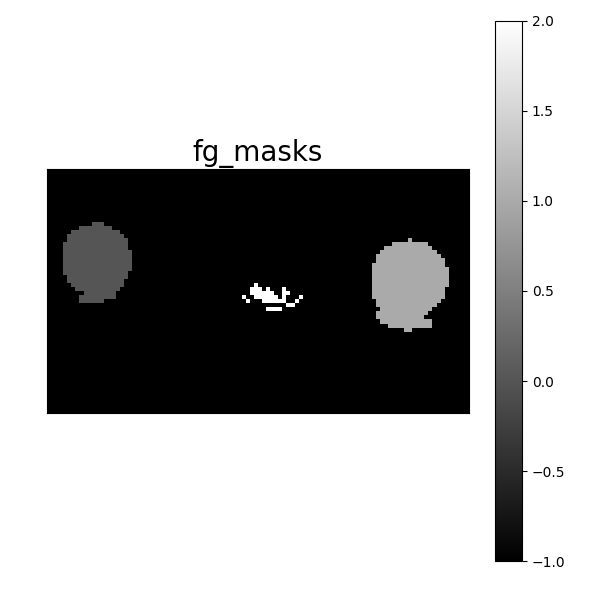

In [74]:
animate_tensor(output, title='fg_masks', fps=5, normalize=False)

In [27]:
output

{'mass_1': tensor(142.),
 'mass_2': tensor(64.2895),
 'mass_3': tensor(364.7048),
 'mass_4': tensor(142.),
 'momentum_1': tensor(8212.0996),
 'momentum_2': tensor(1334.1326),
 'kinetic_energy_1': tensor(1856.6033),
 'kinetic_energy_2': tensor(390.6083)}

TypeError: tuple indices must be integers or slices, not tuple

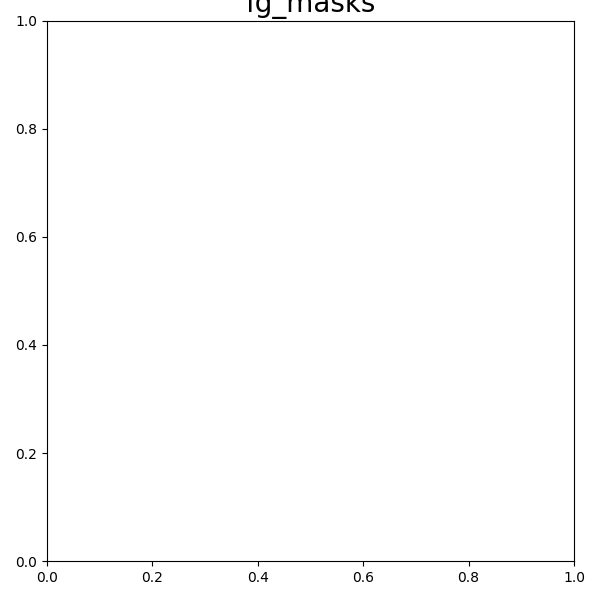

In [258]:
masses.shape

torch.Size([21, 2])

In [265]:
mass_diff = torch.abs(torch.diff(masses, dim=0)) # [f-1, num_objects]
edge_mass = edge_mass[:-1]  # [f-1, num_objects]
mass_diff = F.relu(mass_diff - edge_mass) # if mass_diff < edge_mass, treat mass_diff as 0. Otherwise, treat as is.
conservation_of_mass_loss_1 = mass_diff.sum() # [1], should be zero
conservation_of_mass_loss_2 = torch.var(mass_diff, dim=0).sum() # [1], should be small
conservation_of_mass_loss_3 = torch.var(masses, dim=0).sum() # [1], should be small for each object
conservation_of_mass_loss_4 = torch.abs(mass_diff).sum() # [1], should be small for each object

In [260]:
momentum = masses.unsqueeze(-1) * com_velocities # [f, num_objects, 2]
momentum = momentum[:-1]  # remove last frame which is zero velocity
momentum = momentum.permute(0, 2, 1) # [f-1, 2, num_objects]
momentum = momentum.sum(dim=-1) # [f-1, 2]
momentum_var_loss_1 = torch.var(momentum, dim=0).sum() # [1], should be small on every axis
momentum_var_loss_2 = torch.abs(torch.diff(momentum, dim=0)).sum() # [1], should be small on every axis

In [261]:
kinetic_energy = 0.5 * masses * torch.norm(com_velocities, dim=-1)**2 # [f, num_objects]
kinetic_energy = kinetic_energy[:-1]  # remove last frame which is zero velocity
kinetic_energy = kinetic_energy.sum(dim=-1) # [f-1]
kinetic_energy_loss_1 = torch.var(kinetic_energy, dim=0) # [1], should be small
kinetic_energy_loss_2 = torch.abs(torch.diff(kinetic_energy, dim=0)).sum() # [1], should be small

In [266]:
print(conservation_of_mass_loss_1)
print(conservation_of_mass_loss_2)
print(conservation_of_mass_loss_3)
print(conservation_of_mass_loss_4)
print(momentum_var_loss_1)
print(momentum_var_loss_2)
print(kinetic_energy_loss_1)
print(kinetic_energy_loss_2)

tensor(187.)
tensor(90.7237)
tensor(389.1095)
tensor(187.)
tensor(7880.9414)
tensor(1266.8353)
tensor(1822.3690)
tensor(495.9463)
